# Face Recognition with Deep Metric Learning

useful link:  
http://blog.dlib.net/2017/02/high-quality-face-recognition-with-deep.html  
model: https://github.com/davisking/dlib-models

In [1]:
import dlib
import scipy.misc
import numpy as np
import os
from matplotlib import pyplot as plt

# Part 1: Initialize and Setup

In [2]:
# Get Face Detector from dlib
# This allows us to detect faces in images
face_detector = dlib.get_frontal_face_detector()

# Get Pose Predictor from dlib
# This allows us to detect landmark points in faces and understand the pose/angle of the face
shape_predictor = dlib.shape_predictor('dlib-face-model/shape_predictor_68_face_landmarks.dat')

# Get the face recognition model
# This is what gives us the face encodings (numbers that identify the face of a particular person)
face_recognition_model = dlib.face_recognition_model_v1('dlib-face-model/dlib_face_recognition_resnet_model_v1.dat')

# This is the tolerance for face comparisons
# The lower the number - the stricter the comparison
# To avoid false matches, use lower value
# To avoid false negatives (i.e. faces of the same person doesn't match), use higher value
# 0.5-0.6 works well
TOLERANCE = 0.6

# Part 2: Get face encodings from an image

In [3]:
# This function will take an image and return its face encodings using the neural network
def get_face_encodings(path_to_image):
    # Load image using scipy
    image = scipy.misc.imread(path_to_image)

    # Detect faces using the face detector
    detected_faces = face_detector(image, 1)

    # Get pose/landmarks of those faces
    # Will be used as an input to the function that computes face encodings
    # This allows the neural network to be able to produce similar numbers for faces of the same people, regardless of camera angle and/or face positioning in the image
    shapes_faces = [shape_predictor(image, face) for face in detected_faces]

    # For every face detected, compute the face encodings
    return [np.array(face_recognition_model.compute_face_descriptor(image, face_pose, 1)) for face_pose in shapes_faces]

# Part 3a: Compare faces

In [4]:
# This function takes a list of known faces
def compare_face_encodings(known_faces, face):
    # Finds the difference between each known face and the given face (that we are comparing)
    # Calculate norm for the differences with each known face
    # Return an array with True/Face values based on whether or not a known face matched with the given face
    # A match occurs when the (norm) difference between a known face and the given face is less than or equal to the TOLERANCE value
    return (np.linalg.norm(known_faces - face, axis=1) <= TOLERANCE)

# Part 3b: Find match

In [5]:
# This function returns the name of the person whose image matches with the given face (or 'Not Found')
# known_faces is a list of face encodings
# names is a list of the names of people (in the same order as the face encodings - to match the name with an encoding)
# face is the face we are looking for
def find_match(known_faces, names, face):
    # Call compare_face_encodings to get a list of True/False values indicating whether or not there's a match
    matches = compare_face_encodings(known_faces, face)

    # Return the name of the first match
    count = 0
    for match in matches:
        if match:
            return names[count]
        count += 1

    # Return not found if no match found
    return 'Not Found'

# Part 4a: Getting face encodings for all faces in the images folder

In [6]:
# Get path to all the known images
# Filtering on .jpg extension - so this will only work with JPEG images ending with .jpg
known_img_dir = 'known-image/'
ext = '.jpg'
image_filenames = filter(lambda x: x.endswith(ext), os.listdir(known_img_dir))

# Sort in alphabetical order
image_filenames = sorted(image_filenames)

# Get full paths to images
paths_to_images = [known_img_dir + x for x in image_filenames]

# List of face encodings we have
face_encodings = []

# Loop over images to get the encoding one by one
for path_to_image in paths_to_images:
    # Get face encodings from the image
    face_encodings_in_image = get_face_encodings(path_to_image)

    # Make sure there's exactly one face in the image
    if len(face_encodings_in_image) != 1:
        print("Please change image: " + path_to_image + " - it has " + str(len(face_encodings_in_image)) + " faces; it can only have one")
        exit()

    # Append the face encoding found in that image to the list of face encodings we have
    face_encodings.append(get_face_encodings(path_to_image)[0])   

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


# Part 4b: Matching each image in test folder with the known faces (one by one) 

In [7]:
# Get path to all the test images
# Filtering on .jpg extension - so this will only work with JPEG images ending with .jpg
unknown_img_dir = 'unknown-image/'
test_filenames = filter(lambda x: x.endswith(ext), os.listdir(unknown_img_dir))

# Get full paths to test images
paths_to_test_images = [unknown_img_dir + x for x in test_filenames]

# Get list of names of people by eliminating the .JPG extension from image filenames
names = [x[:-4] for x in image_filenames]

# Iterate over test images to find match one by one
for path_to_image in paths_to_test_images:
    # Get face encodings from the test image
    face_encodings_in_image = get_face_encodings(path_to_image)

    # Make sure there's exactly one face in the image
    if len(face_encodings_in_image) != 1:
        print("Please change image: " + path_to_image + " - it has " + str(len(face_encodings_in_image)) + " faces; it can only have one")
        exit()

    # Find match for the face encoding found in this test image
    match = find_match(face_encodings, names, face_encodings_in_image[0])

    # Print the path of test image and the corresponding match
    print(path_to_image, match)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


('unknown-image/firmino-02.jpg', 'firmino-01')
('unknown-image/buffon-01.jpg', 'buffon-02')
('unknown-image/ronaldo-06.jpg', 'ronaldo-01')
('unknown-image/neymar-03.jpg', 'neymar-01')
('unknown-image/messi-01.jpg', 'messi-02')
('unknown-image/coutinho-03.jpg', 'coutinho-01')


# Test Image

In [8]:
def face_verify(test_image, known_img_dir):
    
    # Get face encodings from the test image
    face_encodings_in_image = get_face_encodings(test_image)
    print "number of face(s) in test image: ", len(face_encodings_in_image)
    
    # Make sure there's exactly one face in the image
    if len(face_encodings_in_image) != 1:
        print("Please change image: - it has " + str(len(face_encodings_in_image)) + " faces; it can only have one")
        exit()
        
    # Find match for the face encoding found in this test image
    match = find_match(face_encodings, names, face_encodings_in_image[0])

    # Print the path of test image and the corresponding match
    #print(path_to_image, match)
    print "Actual image: ", test_image.split('/')[-1].split('-')[0]
    print "Predict image: ", match.split('-')[0]
    
    print "\nTest image"
    plt.imshow(plt.imread(test_image))
    plt.show()

    print "Predict image"
    tmp = known_img_dir + '/' + match + ext
    plt.imshow(plt.imread(tmp))
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  coutinho
Predict image:  coutinho

Test image


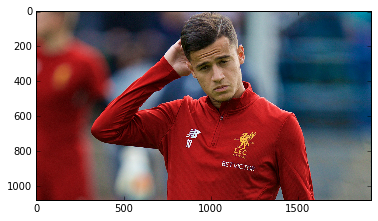

Predict image


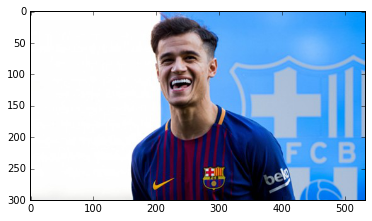

In [9]:
test_image = 'unknown-image/coutinho-03.jpg'
unknown_img_dir = 'unknown-image/'
ext = '.jpg'
known_img_dir = 'known-image/'

test_filenames = filter(lambda x: x.endswith(ext), os.listdir(unknown_img_dir))

# Get full paths to test images
paths_to_test_images = [unknown_img_dir + x for x in test_filenames]

# Get list of names of people by eliminating the .JPG extension from image filenames
names = [x[:-4] for x in image_filenames]

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  ronaldo
Predict image:  ronaldo

Test image


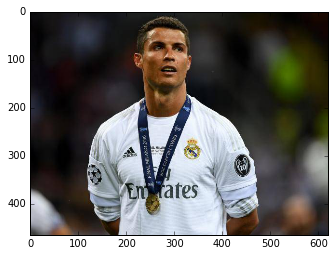

Predict image


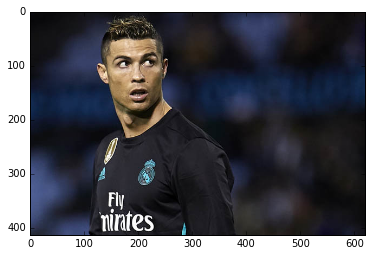

In [10]:
test_image = 'unknown-image/ronaldo-06.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  buffon
Predict image:  buffon

Test image


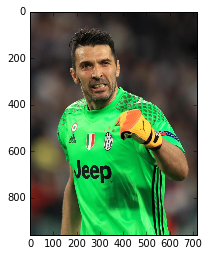

Predict image


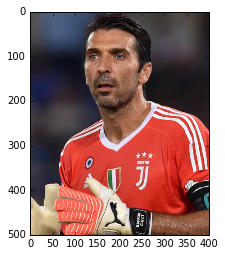

In [11]:
test_image = 'unknown-image/buffon-01.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  firmino
Predict image:  firmino

Test image


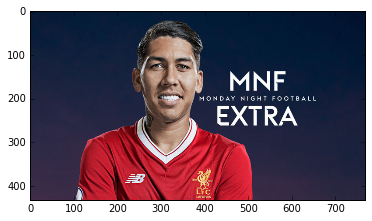

Predict image


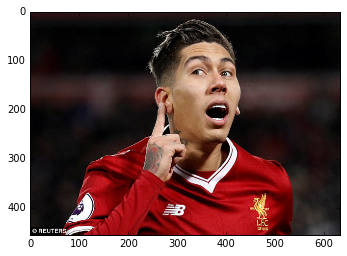

In [12]:
test_image = 'unknown-image/firmino-02.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  neymar
Predict image:  neymar

Test image


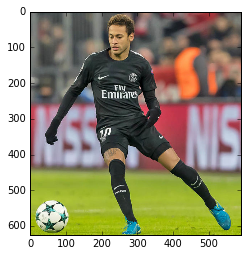

Predict image


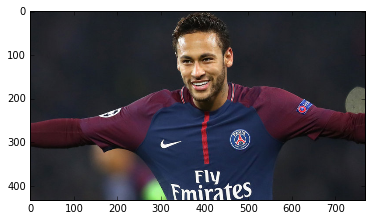

In [13]:
test_image = 'unknown-image/neymar-03.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  neymar
Predict image:  neymar

Test image


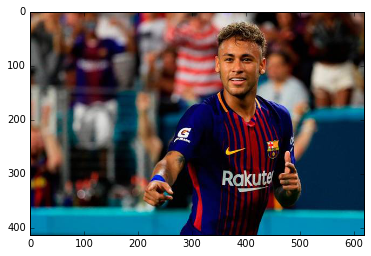

Predict image


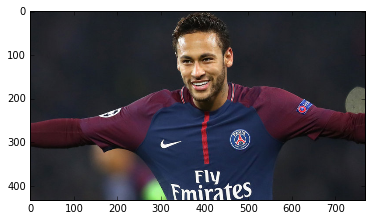

In [14]:
test_image = 'unknown-image/neymar-06.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  1
Actual image:  coutinho
Predict image:  coutinho

Test image


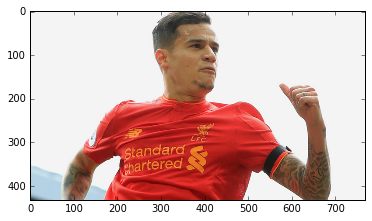

Predict image


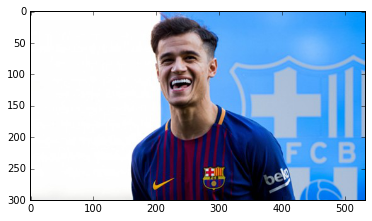

In [15]:
test_image = 'unknown-image/coutinho-04.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


number of face(s) in test image:  2
Please change image: - it has 2 faces; it can only have one
Actual image:  coutinho
Predict image:  coutinho

Test image


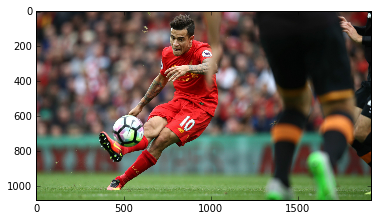

Predict image


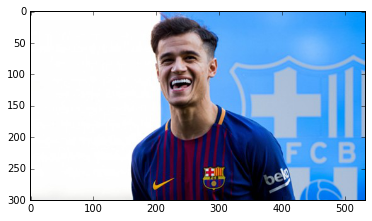

In [ ]:
test_image = 'unknown-image/coutinho-05.jpg'
known_img_dir = 'known-image/'

face_verify(test_image, known_img_dir)